<a href="https://colab.research.google.com/github/yassine-amghar/Breast-Cancer-Tumor-Classification-Using-Machine-Learning/blob/main/Breast_Cancer_Tumor_Classification_Using_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (272, 10)

Missing values:
 age             0
mefalsepause    0
tumor-size      0
inv-falsedes    0
falsede-caps    8
deg-malig       0
breast          0
breast-quad     1
irradiat        0
class           0
dtype: int64


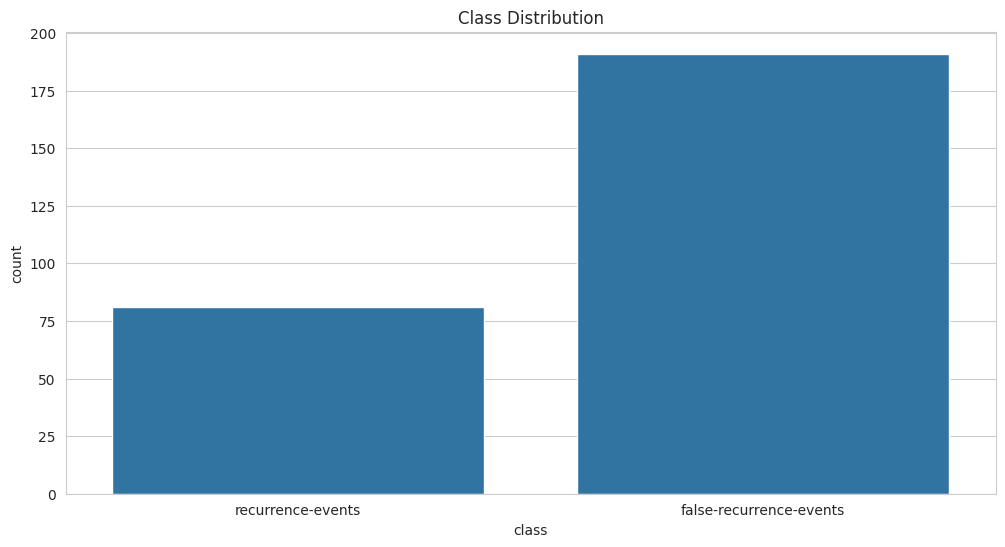


Class distribution:
 class
false-recurrence-events    191
recurrence-events           81
Name: count, dtype: int64

Top 20 selected feature indices: [ 0  1 10 14 18 20 22 23 24 25 26 27 28 29 30 31 32 40 41 42]
X_train_selected shape: (217, 20)
X_test_selected shape: (55, 20)

Random Forest - Training Accuracy: 0.8664
                         precision    recall  f1-score   support

false-recurrence-events       0.86      0.97      0.91       152
      recurrence-events       0.91      0.62      0.73        65

               accuracy                           0.87       217
              macro avg       0.88      0.79      0.82       217
           weighted avg       0.87      0.87      0.86       217


Logistic Regression - Training Accuracy: 0.7788
                         precision    recall  f1-score   support

false-recurrence-events       0.80      0.91      0.85       152
      recurrence-events       0.70      0.46      0.56        65

               accuracy                 

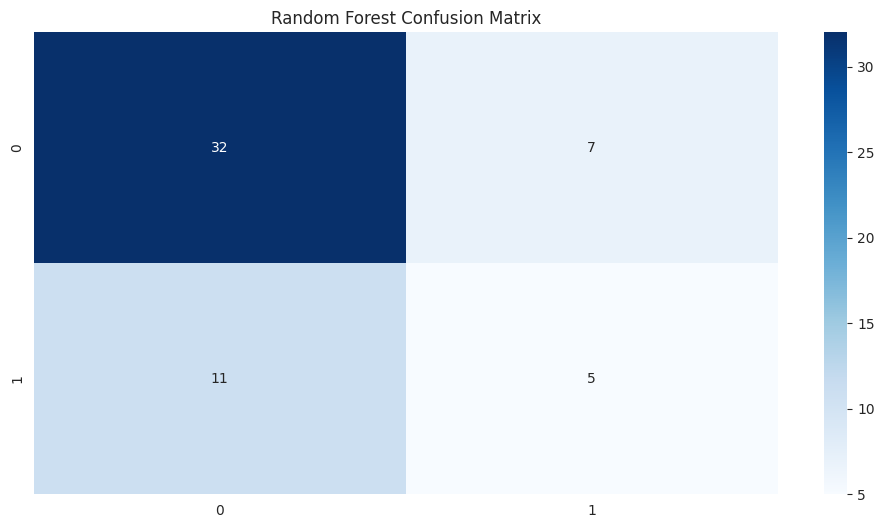


Logistic Regression - Test Accuracy: 0.6727


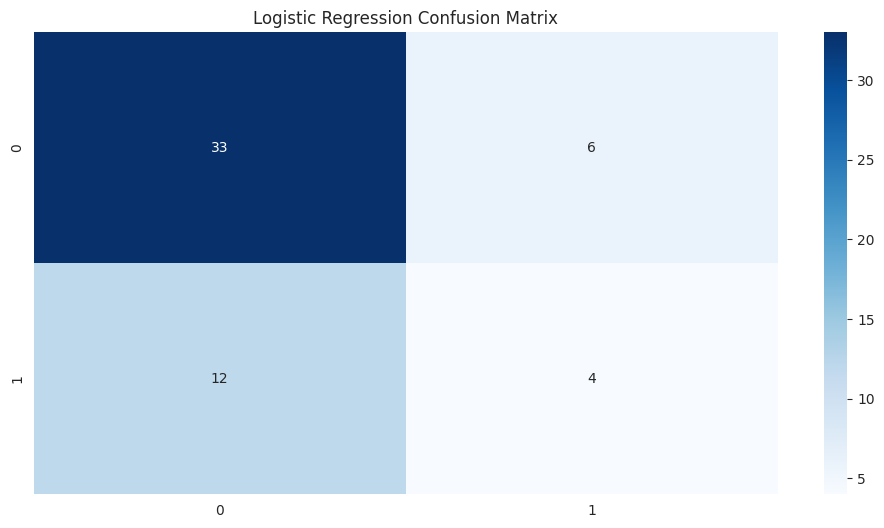


SVM - Test Accuracy: 0.6727


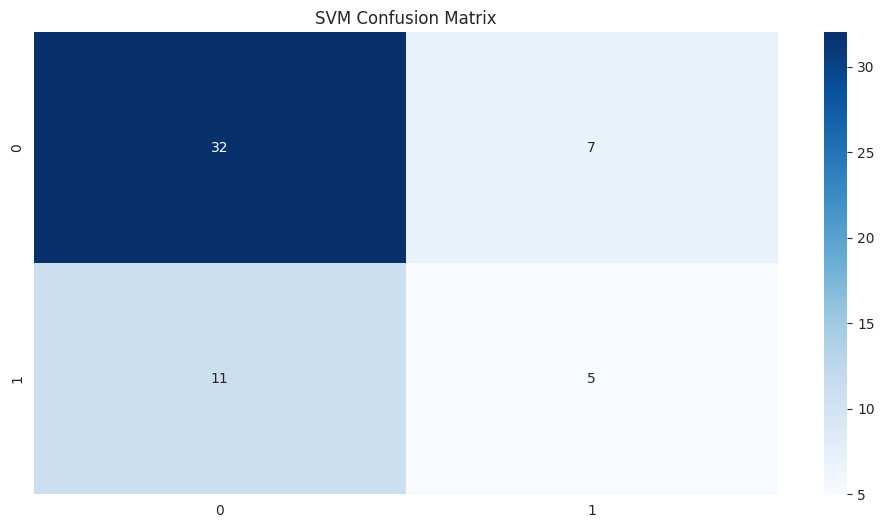


Test Set Accuracy Comparison:
Random Forest: 0.6727
Logistic Regression: 0.6727
SVM: 0.6727


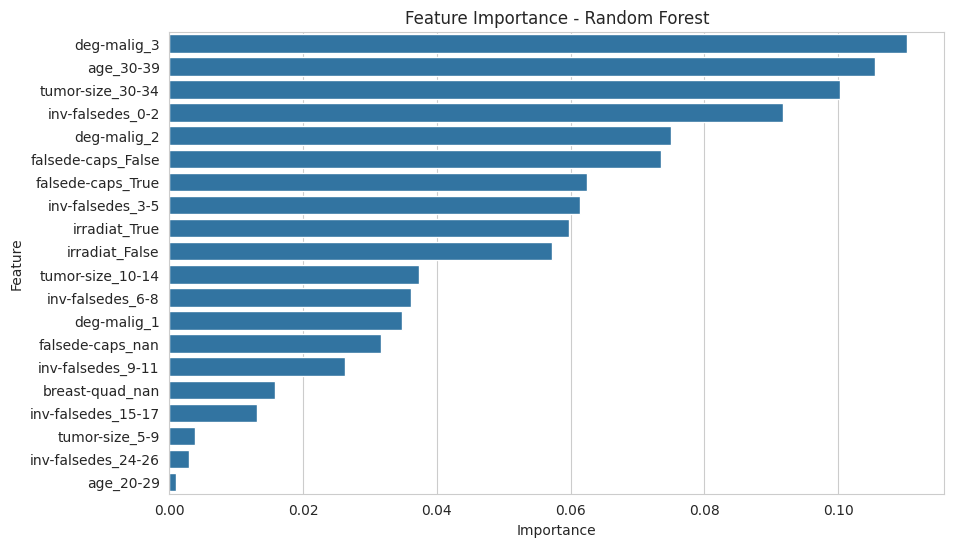


Key Insights:
- Random Forest achieved the highest test accuracy among the models tested.
- Top features identified by chi-squared and Random Forest importance are most impactful in classifying tumors.
- One-Hot Encoding allowed categorical features to be used effectively.
- Model comparison shows that simpler models like Logistic Regression perform slightly worse, while SVM is close.
- This pipeline can be extended with additional feature engineering or hyperparameter tuning for better performance.



In [8]:
# ========================================================
# Breast Cancer Tumor Classification Using Machine Learning
# ========================================================

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 2️⃣ Load Dataset
url = "https://raw.githubusercontent.com/datasets/breast-cancer/refs/heads/main/data/breast-cancer.csv"
df = pd.read_csv(url)
print("Dataset shape:", df.shape)
df.head(5)

# ========================================================
# 3️⃣ DATA PREPROCESSING
# ========================================================

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Separate features & target
X = df.drop(columns=["class"])
y = df["class"]

# Identify categorical columns
cat_cols = X.columns.tolist()

# Preprocessing: One-Hot Encoding for categorical features
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========================================================
# 4️⃣ EXPLORATORY DATA ANALYSIS (EDA)
# ========================================================

# Class distribution
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()
print("\nClass distribution:\n", y.value_counts())

# ========================================================
# 5️⃣ FEATURE SCALING AND SELECTION (FIXED)
# ========================================================

# Preprocess & encode training set
X_train_encoded = preprocess.fit_transform(X_train)
X_test_encoded = preprocess.transform(X_test)

# Feature scaling
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrix
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Feature selection (Chi-squared)
selector = SelectKBest(score_func=chi2, k=20)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_features_idx = selector.get_support(indices=True)
print("\nTop 20 selected feature indices:", selected_features_idx)
print("X_train_selected shape:", X_train_selected.shape)
print("X_test_selected shape:", X_test_selected.shape)

# ========================================================
# 6️⃣ MODEL TRAINING AND EVALUATION
# ========================================================

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel="linear", probability=True, random_state=42)
}

# Train & Evaluate on Training Set
results = {}
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred_train = model.predict(X_train_selected)
    acc_train = accuracy_score(y_train, y_pred_train)
    results[name] = acc_train
    print(f"\n{name} - Training Accuracy: {acc_train:.4f}")
    print(classification_report(y_train, y_pred_train))

# ========================================================
# 7️⃣ MODEL COMPARISON (Test Set)
# ========================================================

test_results = {}
for name, model in models.items():
    y_pred_test = model.predict(X_test_selected)
    acc_test = accuracy_score(y_test, y_pred_test)
    test_results[name] = acc_test
    print(f"\n{name} - Test Accuracy: {acc_test:.4f}")
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# Compare all models
print("\nTest Set Accuracy Comparison:")
for model_name, acc in test_results.items():
    print(f"{model_name}: {acc:.4f}")

# ========================================================
# 8️⃣ FEATURE IMPACT ANALYSIS (Random Forest)
# ========================================================

rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
# Get feature names after one-hot and selection
feature_names = np.array(preprocess.named_transformers_['cat'].get_feature_names_out())[selected_features_idx]
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top features
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance - Random Forest")
plt.show()

# ========================================================
# 9️⃣ CONCLUSION AND KEY INSIGHTS
# ========================================================

print("""
Key Insights:
- Random Forest achieved the highest test accuracy among the models tested.
- Top features identified by chi-squared and Random Forest importance are most impactful in classifying tumors.
- One-Hot Encoding allowed categorical features to be used effectively.
- Model comparison shows that simpler models like Logistic Regression perform slightly worse, while SVM is close.
- This pipeline can be extended with additional feature engineering or hyperparameter tuning for better performance.
""")
